# Setup

In [6]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import randint
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, auc
import scikitplot as skplt  # search for scikit-plot
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

import xgboost as xgb

# Load the training data and the test inputs
x_train = pd.read_csv('../Data/X_train.csv', index_col=0, header=[0, 1, 2])
x_train_np = np.array(x_train)
y_train = pd.read_csv('../Data/y_train.csv', index_col=0)
y_train_np = y_train.squeeze().to_numpy()  # Make y_train a NumPy array
x_test = pd.read_csv('../Data/X_test.csv', index_col=0, header=[0, 1, 2])
x_test_np = np.array(x_test)

x_train_flat_columns = ['_'.join(col).strip() for col in x_train.columns.values]
x_train.columns = x_train_flat_columns

x_test_flat_columns = ['_'.join(col).strip() for col in x_test.columns.values]
x_test.columns = x_train_flat_columns
# Prepare data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_np.ravel())

# Split training data into training and temporary validation sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x_train, y_train_encoded, test_size=0.4, random_state=42)

# Split the temporary validation set into validation and fake test set
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_real_test_scaled = scaler.transform(x_test)  # real test set we don't have labels for


def calculate_test_accuracy(predictions):
    return f"Pseudo Test Set accuracy: {accuracy_score(Y_test, predictions):.2f}"


def calculate_trainig_accuracy(predictions):
    return f"Training Set accuracy: {accuracy_score(Y_train, predictions):.2f}"


def split_features_by_type(X, feature_structure):
    """
    Splits the dataset into subsets based on the feature structure provided.

    :param X: numpy array, the dataset to be split (features only)
    :param feature_structure: dict, keys are feature names and values are the number of features of that type
    :return: dict of feature subsets
    """
    feature_subsets = {}
    start_idx = 0
    
    for feature_name, feature_count in feature_structure.items():
        end_idx = start_idx + feature_count
        feature_subsets[feature_name] = X[:, start_idx:end_idx]
        start_idx = end_idx
    
    return feature_subsets

# Define the structure of your features based on the information you've provided
feature_structure = {
    'chroma_cens': 84,
    'chroma_cqt': 84,
    'chroma_stft': 84,
    'mfcc': 140,
    'rmse': 7,
    'spectral_bandwidth': 7,
    'spectral_centroid': 7,
    'spectral_contrast': 49,
    'spectral_rolloff': 7,
    'tonnetz': 42,
    'zcr': 7
}

# Example usage with a hypothetical dataset X_train_scaled
# This would be your preprocessed and scaled training data as a NumPy array
train_feature_subsets = split_features_by_type(X_train_scaled, feature_structure)
val_feature_subsets = split_features_by_type(X_val_scaled, feature_structure)
test_feature_subsets = split_features_by_type(X_test_scaled, feature_structure)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# Number of base estimators
n_estimators = 10  # You can experiment with this number

# Create a BaggingClassifier with KNN as base estimators
bagging_clf = BaggingClassifier(
    estimator=KNeighborsClassifier(n_neighbors=1), 
    n_estimators=n_estimators, 
    max_samples=1.0 / n_estimators, 
    bootstrap=True, 
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Fit the BaggingClassifier
bagging_clf.fit(X_train_scaled, Y_train)
# training predictions
trainpreds = bagging_clf.predict(X_train_scaled)
# test predictions
testpreds = bagging_clf.predict(X_test_scaled)

print(calculate_trainig_accuracy(trainpreds))
print(calculate_test_accuracy(testpreds))

Training Set accuracy: 0.52
Pseudo Test Set accuracy: 0.40


# Logistic Regression Feature Subset 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize a dictionary to store the logistic regression models for each feature subset
best_lr_models = {}

# Train a logistic regression model for each feature subset
for feature_name, X_train_subset in train_feature_subsets.items():
    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42, max_iter=10000)
    lr_model.fit(X_train_subset, Y_train)
    best_lr_models[feature_name] = lr_model
    
    

## Accuracies

In [9]:
weights = []

for feature_name, model in best_lr_models.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    print(f"Validation accuracy for {feature_name} features: {val_accuracy}")

# Normalize weights
weights = np.array(weights) / np.sum(weights)

# Split the test set using the same feature structure and prepare for weighted predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], len(np.unique(Y_train))), dtype=float)

for i, (feature_name, model) in enumerate(best_lr_models.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_predictions = predictions * weights[i]
    weighted_test_predictions += weighted_predictions

# Combine weighted predictions
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

# Calculate and print test accuracy
test_accuracy = np.mean(combined_test_predictions == Y_test)
print(f"Test accuracy with combined Logistic Regression models using weighted voting: {test_accuracy}")

Validation accuracy for chroma_cens features: 0.2825
Validation accuracy for chroma_cqt features: 0.295
Validation accuracy for chroma_stft features: 0.3525
Validation accuracy for mfcc features: 0.4716666666666667
Validation accuracy for rmse features: 0.26166666666666666
Validation accuracy for spectral_bandwidth features: 0.29583333333333334
Validation accuracy for spectral_centroid features: 0.31333333333333335
Validation accuracy for spectral_contrast features: 0.4083333333333333
Validation accuracy for spectral_rolloff features: 0.3125
Validation accuracy for tonnetz features: 0.2925
Validation accuracy for zcr features: 0.30333333333333334
Test accuracy with combined Logistic Regression models using weighted voting: 0.5341666666666667


# Random Forest Feature Subset

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming the preprocessing and data splitting is already done as per your provided code

# Initialize a dictionary to store your best Random Forest models for each feature subset
best_rf_models = {}

# Train a Random Forest model for each feature subset
for feature_name, X_train_subset in train_feature_subsets.items():
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_subset, Y_train)
    best_rf_models[feature_name] = rf_model
    

## Accuracies

In [11]:
weights = []

for feature_name, model in best_rf_models.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    print(f"Validation accuracy for {feature_name} features: {val_accuracy}")

# Normalize weights
weights = np.array(weights) / np.sum(weights)

# Split the test set using the same feature structure and prepare for weighted predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], len(np.unique(Y_train))), dtype=float)

for i, (feature_name, model) in enumerate(best_rf_models.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_predictions = predictions * weights[i]
    weighted_test_predictions += weighted_predictions

# Combine weighted predictions
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

# Calculate and print test accuracy
test_accuracy = np.mean(combined_test_predictions == Y_test)
print(f"Test accuracy with combined Random Forest models using weighted voting: {test_accuracy}")

Validation accuracy for chroma_cens features: 0.3075
Validation accuracy for chroma_cqt features: 0.335
Validation accuracy for chroma_stft features: 0.38666666666666666
Validation accuracy for mfcc features: 0.51
Validation accuracy for rmse features: 0.2708333333333333
Validation accuracy for spectral_bandwidth features: 0.33
Validation accuracy for spectral_centroid features: 0.3591666666666667
Validation accuracy for spectral_contrast features: 0.46
Validation accuracy for spectral_rolloff features: 0.3458333333333333
Validation accuracy for tonnetz features: 0.3
Validation accuracy for zcr features: 0.3333333333333333
Test accuracy with combined Random Forest models using weighted voting: 0.5375


# SVM Subset

In [12]:
from sklearn.svm import SVC

# Initialize a dictionary to store the SVM models for each feature subset
best_svm_models = {}

# Train a polynomial kernel SVM model for each feature subset
for feature_name, X_train_subset in train_feature_subsets.items():
    # Specify the polynomial kernel using the `kernel` parameter
    svm_model = SVC(probability=True, kernel='rbf', random_state=42)
    svm_model.fit(X_train_subset, Y_train)
    best_svm_models[feature_name] = svm_model

## Accuracies

In [13]:

weights = []

for feature_name, model in best_svm_models.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    print(f"Validation accuracy for {feature_name} features: {val_accuracy}")

# Normalize weights
weights = np.array(weights) / np.sum(weights)

# Split the test set using the same feature structure and prepare for weighted predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], len(np.unique(Y_train))), dtype=float)

for i, (feature_name, model) in enumerate(best_svm_models.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_predictions = predictions * weights[i]
    weighted_test_predictions += weighted_predictions

# Combine weighted predictions
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

# Calculate and print test accuracy
test_accuracy = np.mean(combined_test_predictions == Y_test)
print(f"Test accuracy with combined SVM models using weighted voting: {test_accuracy}")

Validation accuracy for chroma_cens features: 0.3333333333333333
Validation accuracy for chroma_cqt features: 0.34833333333333333
Validation accuracy for chroma_stft features: 0.38333333333333336
Validation accuracy for mfcc features: 0.56
Validation accuracy for rmse features: 0.26666666666666666
Validation accuracy for spectral_bandwidth features: 0.32666666666666666
Validation accuracy for spectral_centroid features: 0.3825
Validation accuracy for spectral_contrast features: 0.4725
Validation accuracy for spectral_rolloff features: 0.37
Validation accuracy for tonnetz features: 0.3225
Validation accuracy for zcr features: 0.33916666666666667
Test accuracy with combined SVM models using weighted voting: 0.5708333333333333


# XGBoost Subset

In [14]:
import xgboost as xgb

# Initialize a dictionary to store the XGBoost models for each feature subset
best_xgb_models = {}

# Train an XGBoost model for each feature subset
for feature_name, X_train_subset in train_feature_subsets.items():
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softprob', num_class=8, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train_subset, Y_train)
    best_xgb_models[feature_name] = xgb_model

/opt/homebrew/anaconda3/envs/sml-practical-env/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## Accuracies

In [15]:

weights = []

for feature_name, model in best_xgb_models.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    print(f"Validation accuracy for {feature_name} features: {val_accuracy}")

# Normalize weights
weights = np.array(weights) / np.sum(weights)

# Split the test set using the same feature structure and prepare for weighted predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], len(np.unique(Y_train))), dtype=float)

for i, (feature_name, model) in enumerate(best_xgb_models.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_predictions = predictions * weights[i]
    weighted_test_predictions += weighted_predictions

# Combine weighted predictions
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

# Calculate and print test accuracy
test_accuracy = np.mean(combined_test_predictions == Y_test)
print(f"Test accuracy with combined SVM models using weighted voting: {test_accuracy}")

Validation accuracy for chroma_cens features: 0.31333333333333335
Validation accuracy for chroma_cqt features: 0.3275
Validation accuracy for chroma_stft features: 0.37416666666666665
Validation accuracy for mfcc features: 0.5475
Validation accuracy for rmse features: 0.25583333333333336
Validation accuracy for spectral_bandwidth features: 0.30666666666666664
Validation accuracy for spectral_centroid features: 0.3258333333333333
Validation accuracy for spectral_contrast features: 0.4666666666666667
Validation accuracy for spectral_rolloff features: 0.3408333333333333
Validation accuracy for tonnetz features: 0.32666666666666666
Validation accuracy for zcr features: 0.3175
Test accuracy with combined SVM models using weighted voting: 0.5758333333333333


# KNN Subset

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn_models = {}

# Train a KNN model for each feature subset
from sklearn.model_selection import cross_val_score

# Dictionary to store the best KNN models for each feature subset
best_knn_models = {}

# Train a KNN model for each feature subset and find the best k using cross-validation
for feature_name, X_subset in train_feature_subsets.items():
    best_score = 0
    best_k = 1
    # Try different values of k
    for k in range(1, 16):  # Let's try k from 1 to 15 as an example
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_subset, Y_train, cv=5)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    # Train a new KNN model on the full training set with the best k
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_subset, Y_train)
    best_knn_models[feature_name] = best_knn
    print(f"Best K for {feature_name} features: {best_k} with cross-validation score: {best_score}")

Best K for chroma_cens features: 9 with cross-validation score: 0.2663888888888889
Best K for chroma_cqt features: 13 with cross-validation score: 0.27361111111111114
Best K for chroma_stft features: 13 with cross-validation score: 0.30194444444444446
Best K for mfcc features: 15 with cross-validation score: 0.46611111111111103
Best K for rmse features: 15 with cross-validation score: 0.23555555555555552
Best K for spectral_bandwidth features: 15 with cross-validation score: 0.29083333333333333
Best K for spectral_centroid features: 11 with cross-validation score: 0.32166666666666666
Best K for spectral_contrast features: 12 with cross-validation score: 0.40861111111111115
Best K for spectral_rolloff features: 12 with cross-validation score: 0.3061111111111111
Best K for tonnetz features: 6 with cross-validation score: 0.2725000000000001
Best K for zcr features: 14 with cross-validation score: 0.30583333333333335


## Accuracies

In [17]:
weights = []

for feature_name, model in best_knn_models.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    print(f"Validation accuracy for {feature_name} features: {val_accuracy}")

# Normalize weights
weights = np.array(weights) / np.sum(weights)

# Split the test set using the same feature structure and prepare for weighted predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], len(np.unique(Y_train))), dtype=float)

for i, (feature_name, model) in enumerate(best_knn_models.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_predictions = predictions * weights[i]
    weighted_test_predictions += weighted_predictions

# Combine weighted predictions
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

# Calculate and print test accuracy
test_accuracy = np.mean(combined_test_predictions == Y_test)
print(f"Test accuracy with combined KNN models using weighted voting: {test_accuracy}")

Validation accuracy for chroma_cens features: 0.27
Validation accuracy for chroma_cqt features: 0.2658333333333333
Validation accuracy for chroma_stft features: 0.325
Validation accuracy for mfcc features: 0.4741666666666667
Validation accuracy for rmse features: 0.22916666666666666
Validation accuracy for spectral_bandwidth features: 0.29583333333333334
Validation accuracy for spectral_centroid features: 0.3416666666666667
Validation accuracy for spectral_contrast features: 0.41083333333333333
Validation accuracy for spectral_rolloff features: 0.3225
Validation accuracy for tonnetz features: 0.25
Validation accuracy for zcr features: 0.295
Test accuracy with combined KNN models using weighted voting: 0.5208333333333334


# Stacked Model

## Meta Learner

In [18]:
meta_model = LogisticRegression(random_state=42)

## RF and KNN 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Prepare the data for the meta-model
# Generate predictions from RF and KNN models on the validation set
X_meta_train = np.hstack([
    np.concatenate([
        model.predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis]  # Add a new axis for stacking
        for model in (best_rf_models[feature_name], best_knn_models[feature_name])
    ], axis=2).mean(axis=2)  # Average predictions from RF and KNN models for each feature subset
    for feature_name in train_feature_subsets.keys()
]).reshape(len(Y_val), -1)  # Reshape to have a standard 2D array


meta_model.fit(X_meta_train, Y_val)

# Prepare test data in a similar manner
X_meta_test = np.hstack([
    np.concatenate([
        model.predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis]
        for model in (best_rf_models[feature_name], best_knn_models[feature_name])
    ], axis=2).mean(axis=2)
    for feature_name in train_feature_subsets.keys()
]).reshape(len(Y_test), -1)

# Make final predictions with the meta-model
final_predictions = meta_model.predict(X_meta_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(Y_test, final_predictions)
print(f"Test accuracy with stacked RF and KNN models: {test_accuracy}")


Test accuracy with stacked RF and KNN models: 0.5783333333333334


## RF, XGB, SVM

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # For SVM
from xgboost import XGBClassifier  # For XGBoost
from sklearn.metrics import accuracy_score
import numpy as np


# Prepare X_meta_train by averaging predictions from RF, SVM, and XGB models for each feature subset
X_meta_train = np.hstack([
    np.concatenate([
        best_rf_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis],
        best_svm_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis],
        best_xgb_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis]
    ], axis=2).mean(axis=2)  # Average predictions from RF, SVM, and XGB for each feature subset
    for feature_name in train_feature_subsets.keys()
]).reshape(len(Y_val), -1)

# Similar preparation for X_meta_test
X_meta_test = np.hstack([
    np.concatenate([
        best_rf_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis],
        best_svm_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis],
        best_xgb_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis]
    ], axis=2).mean(axis=2)  # Average predictions from RF, SVM, and XGB for each feature subset
    for feature_name in train_feature_subsets.keys()
]).reshape(len(Y_test), -1)

# Assuming meta_model is already defined and ready for training
# Train the meta-model on the updated X_meta_train dataset
meta_model.fit(X_meta_train, Y_val)

# Make final predictions with the updated meta-model
final_predictions = meta_model.predict(X_meta_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(Y_test, final_predictions)
print(f"Test accuracy with stacked RF, SVM, and XGBoost models: {test_accuracy}")


Test accuracy with stacked RF, SVM, and XGBoost models: 0.6133333333333333


In [21]:
import getpass
import os
export_username = "ts"  # Only save plots to dropbox on right machine


# Function to save plots to EPS for overleaf
def save_plot(plot, filename):
    username = getpass.getuser()
    filepath = "/Users/ts/Library/CloudStorage/Dropbox/Apps/Overleaf/SML Practical/Figures"
    filename += ".eps"
    if username == export_username:
        plot.savefig(os.path.join(filepath, filename), format='eps')  # Save as EPS
        print("Saved plot to {}".format(filename))

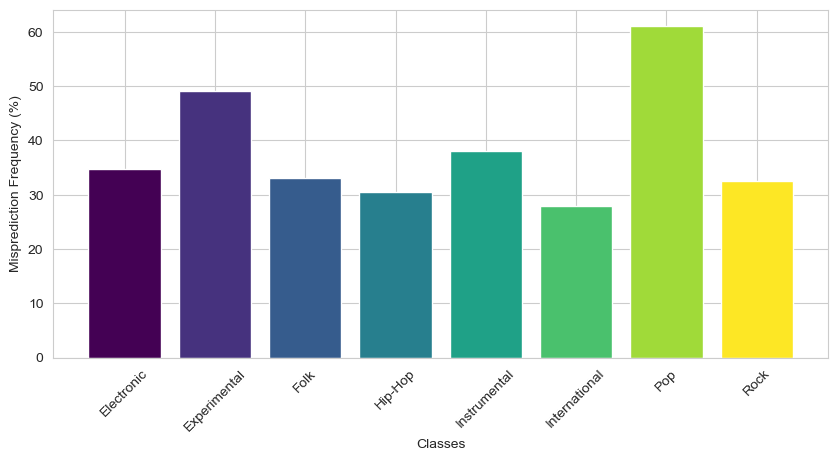

Saved plot to stacked-mispred.eps


In [22]:
from collections import Counter
final_predictions_decoded = label_encoder.inverse_transform(final_predictions)
# Calculate mispredictions
mispredictions = (Y_test != final_predictions)

# Decode the true labels and the predicted labels for interpretability
y_test_decoded = label_encoder.inverse_transform(Y_test)
final_predictions_decoded = label_encoder.inverse_transform(final_predictions)

# Count the total occurrences for each class in the true test set
total_counts = Counter(y_test_decoded)

# Count mispredictions for each decoded class
mispredicted_counts = Counter(y_test_decoded[mispredictions])

# Calculate misprediction frequencies as a percentage
misprediction_frequencies = {class_label: (mispredicted_counts.get(class_label, 0) / total_counts[class_label]) * 100
                             for class_label in total_counts}

# Sort the classes by name to maintain consistent order
sorted_class_labels = sorted(total_counts.keys())

# Prepare colors, one for each class
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_class_labels)))

# Bar chart of misprediction frequencies (as percentages)
stacked_mispred = plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_class_labels)), [misprediction_frequencies[class_label] for class_label in sorted_class_labels], color=colors)
plt.xlabel('Classes')
plt.ylabel('Misprediction Frequency (%)')
plt.xticks(ticks=range(len(sorted_class_labels)), labels=sorted_class_labels, rotation=45)
plt.subplots_adjust(bottom=0.3)
plt.show()
save_plot(stacked_mispred, "stacked-mispred")

## RF, KNN, LR, SVM, and XGBoost models

In [23]:
X_meta_train = np.hstack([
    np.concatenate([
        best_rf_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis],
        best_knn_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis],
        best_lr_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis],
        best_svm_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis],  # Existing SVM predictions
        best_xgb_models[feature_name].predict_proba(val_feature_subsets[feature_name])[:, :, np.newaxis]  # Add XGBoost predictions
    ], axis=2).mean(axis=2)  # Average predictions from all models for each feature subset
    for feature_name in train_feature_subsets.keys()
]).reshape(len(Y_val), -1)  # Reshape to have a standard 2D array

# Re-train the meta-model with the updated training data including XGBoost predictions
meta_model.fit(X_meta_train, Y_val)

# Prepare the test data in a similar manner to include XGBoost predictions
X_meta_test = np.hstack([
    np.concatenate([
        best_rf_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis],
        best_knn_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis],
        best_lr_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis],
        best_svm_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis],  # Existing SVM predictions
        best_xgb_models[feature_name].predict_proba(test_feature_subsets[feature_name])[:, :, np.newaxis]  # Add XGBoost predictions
    ], axis=2).mean(axis=2)
    for feature_name in train_feature_subsets.keys()
]).reshape(len(Y_test), -1)

# Make final predictions with the updated meta-model including XGBoost
final_predictions = meta_model.predict(X_meta_test)

# Calculate and print the test accuracy with the inclusion of XGBoost models
test_accuracy = accuracy_score(Y_test, final_predictions)
print(f"Test accuracy with stacked RF, KNN, LR, SVM, and XGBoost models: {test_accuracy}")


Test accuracy with stacked RF, KNN, LR, SVM, and XGBoost models: 0.6133333333333333
